In [ ]:
%tensorflow_version 2.x
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import OrderedDict
import math
import sys
import time

In [ ]:
FINAL_BATCH_SIZE=10

FINAL_SIZE=256
# Compute patch sizes such that final patches, despite rotation, never have null values
PATCH_SIZE=int(2*FINAL_SIZE/math.sqrt(2.0))

In [ ]:
PATCH_SIZE

362

In [ ]:
# np.set_printoptions(edgeitems=2, linewidth=1000000)

def simple_sample(ds):
  for batch in ds.take(1):
    for key, value in batch.items():
      # print(f"{key:20s}: {value.numpy()} @ {value.shape} / {value.dtype}")
      print(f"{key:20s}: [value] @ {value.shape} / {value.dtype}")
    # print(batch["spatial_data"][0][0])

In [ ]:
organs = ["prostate", "kidney", "liver", "lungs"] # Definitely an incomplete list

MAX_IM_SIZE=3500
MIN_IM_SIZE=2500
# MAX_IM_SIZE=2500; print("USING BAD MAX_IM_SIZE; SHOULD BE 3500")
# MIN_IM_SIZE=1500; print("USING BAD MIN_IM_SIZE; SHOULD BE 2500")

# def sample_spatial_data(image_w_h):
#   image_dims = tf.concat([image_w_h, [3]], axis=-1)
#   seg_dims   = tf.concat([image_w_h, [1]], axis=-1)

#   image_values = tf.cast(tf.random.uniform(shape=image_dims, minval=0, maxval=256, dtype=tf.int32), tf.uint8)
#   seg_values   = tf.cast(tf.random.uniform(shape=seg_dims, minval=0, maxval=2, dtype=tf.int32), tf.uint8)
#   return tf.concat([image_values, seg_values], axis=-1)

def sample_spatial_data(image_w_h):
  image_dims = tf.concat([image_w_h, [3]], axis=-1)
  seg_dims   = tf.concat([image_w_h, [1]], axis=-1)

  image_values = tf.cast(tf.random.uniform(shape=image_dims, minval=0, maxval=1, dtype=tf.float32), tf.float32)
  seg_values   = tf.cast(tf.random.uniform(shape=seg_dims, minval=0, maxval=2, dtype=tf.int32), tf.float32)
  return tf.concat([seg_values, image_values], axis=-1)

def batch_gen():
  while True:
    img_w_h = tf.random.uniform(shape=(2, ), minval=MIN_IM_SIZE, maxval=MAX_IM_SIZE, dtype=tf.int32)
    yield OrderedDict([
      ("id",            tf.random.uniform(shape=(), minval=100, maxval=20000, dtype=tf.int32)),
      ("organ",         tf.gather(organs, tf.random.uniform((),0,tf.size(organs), dtype=tf.int32))),
      ("pixel_size",    tf.random.uniform(shape=(), minval=0.35, maxval=0.55, dtype=tf.float32)),
      ("img_w_h",       img_w_h),
      ("spatial_data",  sample_spatial_data(img_w_h))
    ])

In [ ]:
test_ds = tf.data.Dataset.from_generator(
    batch_gen,
    output_signature= OrderedDict([
             ('id',           tf.TensorSpec(shape=(),                     dtype=tf.int32)),
             ('organ',        tf.TensorSpec(shape=(),                     dtype=tf.string)),
             ('pixel_size',   tf.TensorSpec(shape=(),                     dtype=tf.float32)),
             ('img_w_h',      tf.TensorSpec(shape=(2),                   dtype=tf.int32)),
             ('spatial_data', tf.TensorSpec(shape=(None, None, 4), dtype=tf.float32))])
            #('spatial_data', tf.RaggedTensorSpec(shape=(IMAGE_BATCH_SIZE, None, None, 4), dtype=tf.uint8, ragged_rank=2))])
    )

In [ ]:
simple_sample(test_ds)

id                  : [value] @ () / <dtype: 'int32'>
organ               : [value] @ () / <dtype: 'string'>
pixel_size          : [value] @ () / <dtype: 'float32'>
img_w_h             : [value] @ (2,) / <dtype: 'int32'>
spatial_data        : [value] @ (2993, 2902, 4) / <dtype: 'float32'>


# Data Augmentation

- Technical
  - [ ] Fit on the GPU
  - [ ] Uniform dimension (perhaps around 160px?)
- Performance
  - [x] `pixel_size` / Scaling
  - [x] Rotation
  - [ ] Color Shift
  - [ ] Irregular crop phase
- Meta
  - [x] Distance-from-center metadata

In [ ]:
def augment_spatial_with_dfc(d):
  # The half-width and half-height of the image in micrometers
  um_wh_2 = (tf.cast(d["img_w_h"], tf.float32)*tf.expand_dims(d.pop("pixel_size"), axis=-1))/2.0

  print(um_wh_2)
  
  h_ruler = tf.linspace(-um_wh_2[0], um_wh_2[0], d["img_w_h"][0])
  v_ruler = tf.linspace(-um_wh_2[1], um_wh_2[1], d["img_w_h"][1])
  print(f"H: {h_ruler}\nV: {v_ruler}")

  X, Y = tf.meshgrid(v_ruler, h_ruler)
  X = tf.expand_dims(X, -1)
  Y = tf.expand_dims(Y, -1)
  # print(f"X: {X}\nY: {Y}")
  # Dist = tf.math.sqrt(tf.math.square(X) + tf.math.square(Y))
  # sinX = tf.math.sin(X * math.pi * 2)
  # sinY = tf.math.sin(Y * math.pi * 2)

  # sinX10 = tf.math.sin(X * math.pi * 0.2)
  # sinY10 = tf.math.sin(Y * math.pi * 0.2)

  d["spatial_data"] = tf.concat([d["spatial_data"], X, Y], axis=-1)
  # d["spatial_data"] = tf.concat([d["spatial_data"], Dist], axis=-1)
  # d["spatial_data"] = tf.concat([d["spatial_data"], Dist, X, Y], axis=-1)
  # d["spatial_data"] = tf.concat([d["spatial_data"], Dist, sinX, sinY, sinX10, sinY10], axis=-1)

  return d

ds_dfc = test_ds.map(augment_spatial_with_dfc)
# simple_sample(ds_dfc)

Tensor("truediv:0", shape=(2,), dtype=float32)
H: Tensor("linspace/Slice:0", shape=(None,), dtype=float32)
V: Tensor("linspace_1/Slice:0", shape=(None,), dtype=float32)


In [ ]:
simple_sample(ds_dfc)

id                  : [value] @ () / <dtype: 'int32'>
organ               : [value] @ () / <dtype: 'string'>
img_w_h             : [value] @ (2,) / <dtype: 'int32'>
spatial_data        : [value] @ (3035, 2749, 6) / <dtype: 'float32'>


In [ ]:
def apply_patching(d):
  d["spatial_data"] = tf.image.extract_patches(tf.expand_dims(d.pop("spatial_data"), axis=0),
                                          sizes  = [1, PATCH_SIZE, PATCH_SIZE, 1],
                                          strides= [1, FINAL_SIZE//2, FINAL_SIZE//2, 1],
                                          rates  = [1, 1, 1, 1],
                                          padding="VALID")
  d.pop("img_w_h")
  return d

def patches_to_batch(d, num_channels=6):
  # spatial_data = d["spatial_data"]
  d["spatial_data"] = tf.reshape(d["spatial_data"], [-1, PATCH_SIZE, PATCH_SIZE, num_channels])
  d["organ"] = tf.repeat(d["organ"], tf.shape(d["spatial_data"])[0], axis=-1)
  d["id"] = tf.repeat(d["id"], tf.shape(d["spatial_data"])[0], axis=-1)
  return d



In [ ]:
ds_patched = ds_dfc.map(apply_patching)
ds_patchstack = ds_patched.map(patches_to_batch)
ds_patch_unbatch = ds_patchstack.unbatch()
ds_patchbatch = ds_patch_unbatch.batch(FINAL_BATCH_SIZE)

In [ ]:
simple_sample(ds_patched)
start_time = time.perf_counter()

simple_sample(ds_patched)
print(time.perf_counter()-start_time, "\n")
start_time = time.perf_counter()

simple_sample(ds_patchstack)
print(time.perf_counter()-start_time, "\n")
start_time = time.perf_counter()

simple_sample(ds_patch_unbatch)
print(time.perf_counter()-start_time, "\n")
start_time = time.perf_counter()

simple_sample(ds_patchbatch)
print(time.perf_counter()-start_time, "\n")

id                  : [value] @ () / <dtype: 'int32'>
organ               : [value] @ () / <dtype: 'string'>
spatial_data        : [value] @ (1, 23, 17, 786264) / <dtype: 'float32'>
id                  : [value] @ () / <dtype: 'int32'>
organ               : [value] @ () / <dtype: 'string'>
spatial_data        : [value] @ (1, 20, 21, 786264) / <dtype: 'float32'>
10.324025508998602 

id                  : [value] @ (432,) / <dtype: 'int32'>
organ               : [value] @ (432,) / <dtype: 'string'>
spatial_data        : [value] @ (432, 362, 362, 6) / <dtype: 'float32'>
10.349760445998982 



KeyboardInterrupt: ignored

In [ ]:
def embed_organ_onehots(d):
  input = d.pop("organ")
  onehot = tf.cast(tf.stack([tf.equal(input, s) for s in organs], axis=-1), dtype=tf.float32)
  onehot = tf.reshape(onehot, [-1, 1, 1, len(organs)])
  print(onehot)
  onehotshape = tf.concat([[1], tf.shape(d["spatial_data"])[1:3], [1]], axis=-1)
  print(onehotshape)
  onehot = tf.tile(onehot, onehotshape)
  print("OneHot:", onehot)
  d["spatial_data"] = tf.concat([d["spatial_data"], onehot], axis=-1)
  return d

ds_all_spatial = ds_patchbatch.map(embed_organ_onehots)

Tensor("Reshape:0", shape=(None, 1, 1, 4), dtype=float32)
Tensor("concat:0", shape=(4,), dtype=int32)
OneHot: Tensor("Tile:0", shape=(None, 362, 362, 4), dtype=float32)


In [ ]:
simple_sample(ds_all_spatial)

id                  : [value] @ (10,) / <dtype: 'int32'>
spatial_data        : [value] @ (10, 362, 362, 10) / <dtype: 'float32'>


In [ ]:
augmentation = tf.keras.Sequential([
                                    tf.keras.layers.RandomFlip(),
                                    tf.keras.layers.RandomRotation(1),
                                    tf.keras.layers.RandomZoom(
                                        (
                                            -1*(1-(1/math.sqrt(2))), 
                                            -0.8
                                        )
                                    ),
                                    tf.keras.layers.RandomCrop(FINAL_SIZE, FINAL_SIZE),

])
def apply_augmentation(d):
  d["spatial_data"] = augmentation(d["spatial_data"])
  return d

In [ ]:
ds_augmented = ds_all_spatial.map(apply_augmentation)

In [ ]:
def embed_positional_metadata(d):
  XY = d["spatial_data"][:, :, :, 4:6]
  print(XY)


  XYSquaredSum = tf.reduce_sum(tf.math.square(XY), axis=-1)
  print(XYSquaredSum)
  DistFromCenter = tf.math.sqrt(
    tf.reduce_sum(
        tf.math.square(XY), 
        axis=-1,
        keepdims=True
    )
  )
  
  print(DistFromCenter)

  ## Why am I using sine here, and why am I allowing it to use the camera's reference frame?
  ## Great question. Sine is being used to convey information about the original scale of the image, such that one cycle is one micrometer.
  ## This grid is being computed in the camera's reference frame, but it's been rotated randomly (physically by the doctor, then virtually by the data pipeline),
  ## so there's no information embedded in its orientation.
  PosSin = tf.math.sin(XY * math.pi * 2)
  PosSin10 = tf.math.sin(XY * math.pi * 0.2)
  

  d["spatial_data"] = tf.concat([
                                  d["spatial_data"][..., :4], 
                                  d["spatial_data"][..., 6:], 
                                  # d["spatial_data"],
                                  DistFromCenter, PosSin, PosSin10
                                ],
                                axis=-1
                                )

  return d

In [ ]:
ds_positional_metadata = ds_augmented.map(embed_positional_metadata)

Tensor("strided_slice:0", shape=(None, 256, 256, 2), dtype=float32)
Tensor("Sum:0", shape=(None, 256, 256), dtype=float32)
Tensor("Sqrt:0", shape=(None, 256, 256, 1), dtype=float32)


In [ ]:
simple_sample(ds_positional_metadata)

id                  : [value] @ (10,) / <dtype: 'int32'>
spatial_data        : [value] @ (10, 256, 256, 13) / <dtype: 'float32'>


In [ ]:
def add_empty_channels(img, num_empty_channels=1):
  zeros = np.zeros_like(img[:, :, 0:1])
  zeros = np.repeat(zeros, num_empty_channels, axis=-1)
  return np.concatenate([img, zeros], axis=-1)

def imshow_colorbar(img):
  fig, ax = plt.subplots()
  show = ax.imshow(img)
  bar = plt.colorbar(show)
  plt.show()

In [ ]:
aug_sample = next(iter(ds_positional_metadata.take(1)))

In [ ]:
aug_img = aug_sample["spatial_data"]

In [ ]:
aug_img.shape

TensorShape([10, 256, 256, 13])

In [ ]:
test_sample = -1

In [ ]:
test_sample += 1

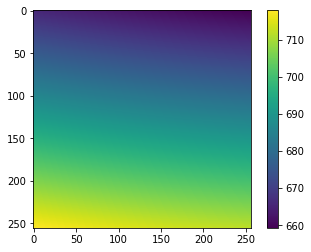

In [ ]:
imshow_colorbar(aug_img[test_sample, :, :, 8])